<a href="https://colab.research.google.com/github/jessysu/cpia/blob/master/CPIA_demo_on_BigGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to Google Drive

For storing the output frames and video

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [0]:
import os
from os import makedirs
import time
import datetime
import tqdm
import itertools
import numpy as np
from scipy.ndimage import gaussian_filter

import torch as t
import torch.nn as nn
import torchvision as tv
from torchsummary import summary
from collections import OrderedDict


import re

import torch

from PIL import Image
import cv2
import imageio

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator



from torch.nn import init
import functools


# Install BigGAN

In [27]:
!pip install pytorch-pretrained-biggan
!pip install libsixel-python

# Prepare BigGAN and Check Its Architecture

In [28]:
import torch
import nltk
nltk.download('wordnet')

from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample,
                                       save_as_images, display_in_terminal)
model = BigGAN.from_pretrained('biggan-deep-512')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


BigGAN(
  (embeddings): Linear(in_features=1000, out_features=128, bias=False)
  (generator): Generator(
    (gen_z): Linear(in_features=256, out_features=32768, bias=True)
    (layers): ModuleList(
      (0): GenBlock(
        (bn_0): BigGANBatchNorm(
          (scale): Linear(in_features=256, out_features=2048, bias=False)
          (offset): Linear(in_features=256, out_features=2048, bias=False)
        )
        (conv_0): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1))
        (bn_1): BigGANBatchNorm(
          (scale): Linear(in_features=256, out_features=512, bias=False)
          (offset): Linear(in_features=256, out_features=512, bias=False)
        )
        (conv_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn_2): BigGANBatchNorm(
          (scale): Linear(in_features=256, out_features=512, bias=False)
          (offset): Linear(in_features=256, out_features=512, bias=False)
        )
        (conv_2): Conv2d(512, 512, kernel_size=(3, 

# Channel Painter Class

In [0]:
class BGANdraw(nn.Module):
    def __init__(self, model, z, class_label, truncation=0.4, TEXT_OUT=None):
        assert 0 < truncation <= 1
        
        super(BGANdraw, self).__init__()
        self.model = model
        self.generator = model.generator
        self.truncation = truncation
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        embed = model.embeddings(class_label)
        self.cond_vector = torch.cat((z, embed), dim=1).to(self.device)
        self.TEXT_OUT = TEXT_OUT


    def pregen(self):
        z = self.generator.gen_z(self.cond_vector)
        z = z.view(-1, 4, 4, 16 * self.generator.config.channel_width)
        z = z.permute(0, 3, 1, 2).contiguous()
        return z

    def procgen(self, z, layers):
        
        if not isinstance(layers, torch.nn.ModuleList):
            if layers.__class__.__name__ == 'SelfAttn':
                z = layers(z)
            else:
                z = layers(z, self.cond_vector, self.truncation)
            return z
        
        for layer in layers:
            if layer.__class__.__name__ == 'GenBlock':
                z = layer(z, self.cond_vector, self.truncation)
            else:
                z = layer(z)
        return z
    
    def postgen(self, z):
        z = self.generator.bn(z, self.truncation)
        z = self.generator.relu(z)
        z = self.generator.conv_to_rgb(z)
        z = z[:, :3, ...]
        z = self.generator.tanh(z)
        return z

    def setPainterLayer(self, pl, bn=True, max_ch=50, stop_stroke=False, full_stroke=True, new_frame_ch=False, random_walk=0, penetrate=0, stop_threshold=1.0
                        , stroke_size=0, stroke_scope=20, continuous_stroke=True, min_stroke_match=0.6, min_stroke_check=10
                        , channel_cost=0.6, move_cost=1.5, bias_cost=0.2, bias_cost_first=0.9, bias_centrality=2.0
                       ):
        print("paint layer = " + str(pl) + " out of " + str(len(self.generator.layers)) + " layers")
        if pl >= len(self.generator.layers):
            return None
        self.prePaint = self.generator.layers[:pl]
        self.postPaint = self.generator.layers[pl+1:]
        self.paintLayer = self.generator.layers[pl]
        X = self.pregen().to(self.device)
        self.X = X.clone().detach()
        
        X = self.procgen(X, self.prePaint)
        print("painter layer input " + str(X.size()))
        R = self.procgen(X, self.paintLayer)
        print("painter layer output " + str(R.size()))
        if self.TEXT_OUT:
            self.TEXT_OUT.write("painter layer input " + str(X.size()) + "\n")
            self.TEXT_OUT.write("painter layer output " + str(R.size()) + "\n")
        (b, ch, h, w) = R.size()
        self.M = torch.zeros(1, ch, h, w).to(self.device)
        
        self.bn = bn
        self.max_ch = max_ch
        self.new_frame_ch = new_frame_ch
        self.stop_stroke = stop_stroke
        self.full_stroke = full_stroke
        self.stroke_size = stroke_size
        if stroke_scope < 2 * stroke_size:
            stroke_scope = 2 * stroke_size
        self.stroke_scope = stroke_scope
        self.stop_threshold = stop_threshold
        self.continuous_stroke = continuous_stroke
        self.min_stroke_match = min_stroke_match
        cch = (ch if full_stroke else max_ch)
        #self.max_stroke_check = max(min_stroke_check, int( (2*stroke_scope+1) ** 2 * cch * (1-min_stroke_match)**np.log2(cch) ) )
        self.max_stroke_check = max(min_stroke_check, int( (2*stroke_scope+1) ** 2 * (1-min_stroke_match) ) )
        print("max_stroke_check = " + str(self.max_stroke_check))
        self.random_walk = random_walk
        self.penetrate = min(penetrate, ch)
        
        self.channel_cost = channel_cost
        self.move_cost = move_cost
        self.bias_cost = bias_cost
        self.bias_cost_first = bias_cost_first
        self.bias_centrality = bias_centrality
        
        R = self.procgen(R, self.postPaint)
        return self.postgen(R)

    def outPainter(self, M=None):
        X = self.procgen(self.X.clone().detach(), self.prePaint)
        if M is None:
            X = self.M * self.procgen(X, self.paintLayer)
        else:
            X = M * self.procgen(X, self.paintLayer)
        X = self.procgen(X, self.postPaint)
        return self.postgen(X)
    
    def setPainterJob(self):
        R = self.procgen(self.X.clone().detach(), self.prePaint)
        R = self.procgen(R, self.paintLayer)
        (b, ch, h, w) = R.size()
        f = nn.BatchNorm2d(ch, affine=False).to(self.device)
        R = f(R)
        R = torch.abs(R)
        r = R.view(1, -1).argsort(1, descending=True)
        self.indices = torch.cat(((r / (h*w)).view(-1, 1), ((r % (h*w)) / w).view(-1, 1), ((r % (h*w)) % w).view(-1, 1)), dim=1).view(-1, 3)
        self.R = R
        self.lastStroke = None
        
    def setPainterState(self, lastStroke, M):
        self.lastStroke = lastStroke
        self.M = M

    def getPainterState(self):
        return (self.lastStroke, self.M)

    
    def getFixedChPaint(self):
        (b, ch, h, w) = self.R.size()
        ch = min(self.max_ch, ch)
        s = self.R.argsort(1, descending=True)
        M = torch.zeros(1).expand_as(self.R).to(self.device).scatter(1, s[:,:ch,:,:], torch.ones(1).expand_as(s[:,:ch,:,:]).to(self.device))
        return self.outPainter(M)
        
    def getPainterLoc(self, loop_id=0, n=1):
        R = self.R.clone().detach()
        R = R * 1e7
        (b, ch, h, w) = R.size()
        
        # remove masked
        R = R - self.M * R
        
        # weighting conditions
        if not self.lastStroke is None:
            # movement cost
            G = np.zeros((h,w))
            G[self.lastStroke[1], self.lastStroke[2]] = 1.0
            G = gaussian_filter(G, sigma=max(h,w)/(self.move_cost+1e-3), truncate=2, mode='constant')
            G = torch.from_numpy(G).float().to(self.device)
            R = R * G
            
            # channel cost
            G = torch.ones_like(R) * (1-self.channel_cost)
            G[:, self.lastStroke[0], :, :] = 1.0
            R = R * G
        
        bias_cost = (self.bias_cost_first - self.bias_cost)/(loop_id + 1) + self.bias_cost
        
        G = np.zeros((h,w))
        G[int(h/2), int(w/2)] = 1.0
        G = gaussian_filter(G, sigma=max(h,w)/(self.bias_centrality+1e-3), mode='constant')
        G = (G - G.min()) / (G.max() - G.min())
        G = torch.from_numpy(G).float().to(self.device)
        G = (1 - bias_cost) + bias_cost * G
        R = R * G
            
        # reached max strokes
        if self.stop_stroke:
            G = self.M.sum(1)
            G = torch.where( G < self.max_ch, torch.ones(1).expand_as(G).to(self.device), torch.zeros(1).expand_as(G).to(self.device))
            G = G.repeat(ch, 1, 1).unsqueeze(0)
            R = R * G

        
        r = R.view(1, -1).argsort(1, descending=True)
        indices = torch.cat(((r / (h*w)).view(-1, 1), ((r % (h*w)) / w).view(-1, 1), ((r % (h*w)) % w).view(-1, 1)), dim=1).view(-1, 3)
        i = indices[0]
        
        if self.random_walk:
            weights = []
            for i in indices[:self.random_walk]:
                weights.append(R[0, i[0], i[1], i[2]])
            weights = torch.tensor(weights, dtype=torch.float).to(self.device)
            sampled = torch.multinomial(weights, self.random_walk)
            indices = indices[sampled]
        
        return indices[:n]
    
    def paintStrokeIn(self, ch, y, x, bump_neighbor=0.5):
        self.isStrokeIn = True
        self.r0 = self.R[0, ch, y, x]
        s = self.stroke_scope
        
        self.indices0 = self.indices.clone().detach()
        self.indices0 = self.indices0[torch.abs(self.indices0[:,1]-y) <= s, :]
        self.indices0 = self.indices0[torch.abs(self.indices0[:,2]-x) <= s, :]
        if not self.full_stroke:
            self.indices0 = self.indices0[self.indices0[:,0]==ch, :]
            self.indices0 = self.indices0[self.M[0,self.indices0[:,0],self.indices0[:,1],self.indices0[:,2]] < 1.0, :]
        
    def paintStrokeOut(self):
        self.isStrokeIn = False
        
        

    
    def paintStrokeContinuous(self, i):
        y = i[1]
        x = i[2]
        m_updated = 0
        m_gain = 0
        if not self.full_stroke:
            if penetrate > 0:
                ch = self.R[0, :, i[1], i[2]]
                ch = ch * (1 - self.M[0, :, i[1], i[2]])
                allowed = int(min(self.penetrate, (self.max_ch - self.M[0, :, i[1], i[2]].sum()).cpu().numpy()))
                ch = ch.sort(descending=True)[1][:allowed+1]
            else:
                ch = i[0]

        for id, j in enumerate(self.indices0):
            if self.R[0, j[0], j[1], j[2]] / (self.r0 + 1e-6) < self.min_stroke_match:
                #print("Rj[0, "+str(j[0].data.cpu().numpy())+", "+str(j[1].data.cpu().numpy())+", "+str(j[2].data.cpu().numpy())+"] = " + str(self.R[0, j[0], j[1], j[2]].data.cpu().numpy()) + " < " + str(self.min_stroke_match) + " * R[0, "+str(i[0].data.cpu().numpy())+", "+str(i[1].data.cpu().numpy())+", "+str(i[2].data.cpu().numpy())+"] = " + str(self.r0.data.cpu().numpy()) + "  m_updated " + str(m_updated) + " after " + str(id) + " checks")
                if self.TEXT_OUT:
                    self.TEXT_OUT.write("Rj[0, "+str(j[0].data.cpu().numpy())+", "+str(j[1].data.cpu().numpy())+", "+str(j[2].data.cpu().numpy())+"] = " + str(self.R[0, j[0], j[1], j[2]].data.cpu().numpy()) + " < " + str(self.min_stroke_match) + " * R[0, "+str(i[0].data.cpu().numpy())+", "+str(i[1].data.cpu().numpy())+", "+str(i[2].data.cpu().numpy())+"] = " + str(self.r0.data.cpu().numpy()) + "  m_updated " + str(m_updated) + " after " + str(id) + " checks" + "\n")
                break
            if id > self.max_stroke_check:
                print("reached "+str(self.max_stroke_check)+" stroke checks. R[0, "+str(i[0].data.cpu().numpy())+", "+str(i[1].data.cpu().numpy())+", "+str(i[2].data.cpu().numpy())+"] = " + str(self.r0.data.cpu().numpy()) + "  m_updated " + str(m_updated) + " after " + str(id) + " checks")
                if self.TEXT_OUT:
                    self.TEXT_OUT.write("reached "+str(self.max_stroke_check)+" stroke checks. R[0, "+str(i[0].data.cpu().numpy())+", "+str(i[1].data.cpu().numpy())+", "+str(i[2].data.cpu().numpy())+"] = " + str(self.r0.data.cpu().numpy()) + "  m_updated " + str(m_updated) + " after " + str(id) + " checks" + "\n")
                break
            # masked
            if self.M[0, j[0], j[1], j[2]] >= 1.0:
                continue
            # outside stroke_scope
            if j[1] < y-self.stroke_scope or j[1] > y+self.stroke_scope or j[2] < x-self.stroke_scope or j[2] > x+self.stroke_scope:
                continue
            if self.full_stroke:
                self.M[0, :, max(j[1]-self.stroke_size,0):min(j[1]+self.stroke_size+1,h), max(j[2]-self.stroke_size,0):min(j[2]+self.stroke_size+1,w)] = 1
            elif j[0] == i[0]:
                self.M[0, ch, max(j[1]-self.stroke_size,0):min(j[1]+self.stroke_size+1,h), max(j[2]-self.stroke_size,0):min(j[2]+self.stroke_size+1,w)] = 1
            m_updated += 1
            m_gain += self.R[0, j[0], j[1], j[2]]
        
        
    def paint(self, loop_id, u_size=10):
        cur_ch = -1
        ch_stop = False
        
        if u_size < 1:
            u_size = 1
        u_size = int(u_size)
        print("loop " + str(loop_id) + " u_size = " +str(u_size))
        if self.TEXT_OUT:
            self.TEXT_OUT.write("loop " + str(loop_id) + " u_size = " +str(u_size) + "\n")
        n_updated = 0
        sum_gain  = 0.0
        
        (b, ch, h, w) = self.M.size()
        Ms = self.M.sum(1)
        while n_updated < u_size:
            i = self.getPainterLoc(loop_id, n=1)[0]
            
            if cur_ch >=0 and i[0] != cur_ch:
                ch_stop = True
                if self.new_frame_ch and n_updated >  0.2 * u_size:
                    break
            
            # stop if drawing too detail
            if self.R[0, i[0], i[1], i[2]]<self.stop_threshold:
                print("Stopped on response value "+str(self.R[0, i[0], i[1], i[2]]))
                if self.TEXT_OUT:
                    self.TEXT_OUT.write("Stopped on response value "+str(self.R[0, i[0], i[1], i[2]]) + "\n")
                break
            
            if self.M[0, i[0], i[1], i[2]] >= 1.0:
                print("skip masked i = " + str(i) + " with R = " + str(self.R[0, i[0], i[1], i[2]]))
                if self.TEXT_OUT:
                    self.TEXT_OUT.write("skip masked i = " + str(i) + " with R = " + str(self.R[0, i[0], i[1], i[2]]) + "\n")
                if self.lastStroke is None:
                    print("No place to stroke")
                    if self.TEXT_OUT:
                        self.TEXT_OUT.write("No place to stroke\n")
                    break
                else:
                    self.lastStroke = None
                    print("Reset stroke")
                    if self.TEXT_OUT:
                        self.TEXT_OUT.write("Reset stroke\n")
                    continue
            
            if self.stop_stroke and Ms[0, i[1], i[2]] >= self.max_ch:
                print("skip max channel i = " + str(i) + " with R = " + str(self.R[0, i[0], i[1], i[2]]) + " Ms = " + str(Ms[0, i[1], i[2]]))
                if self.TEXT_OUT:
                    self.TEXT_OUT.write("skip max channel i = " + str(i) + " with R = " + str(self.R[0, i[0], i[1], i[2]]) + " Ms = " + str(Ms[0, i[1], i[2]]) + "\n")
                if self.lastStroke is None:
                    print("No place to stroke")
                    if self.TEXT_OUT:
                        self.TEXT_OUT.write("No place to stroke\n")
                    break
                else:
                    self.lastStroke = None
                    print("Reset stroke")
                    if self.TEXT_OUT:
                        self.TEXT_OUT.write("Reset stroke\n")
                    continue
            
            n_updated += 1
            sum_gain += self.R[0, i[0], i[1], i[2]]
            
            if self.full_stroke:
                self.M[0, :, max(i[1]-self.stroke_size,0):min(i[1]+self.stroke_size+1,h), max(i[2]-self.stroke_size,0):min(i[2]+self.stroke_size+1,w)] = 1
            else:
                self.M[0, i[0], max(i[1]-self.stroke_size,0):min(i[1]+self.stroke_size+1,h), max(i[2]-self.stroke_size,0):min(i[2]+self.stroke_size+1,w)] = 1

            if self.continuous_stroke:
                self.paintStrokeIn(i[0], i[1], i[2])
                self.paintStrokeContinuous(i)
                self.paintStrokeOut()
                        
            
            # add count if drawing too many times on same place
            Ms[0, i[1], i[2]] += 1.0
            if Ms[0, i[1], i[2]] > self.max_ch:
                u_size += 1
            
            self.lastStroke = i
            cur_ch = i[0]

            
        # release stroke when no stroke move (under continuous stroke)
        if n_updated==0 and self.isStrokeIn:
            self.paintStrokeOut()
        print("n_updated = " + str(n_updated))
        print("Mask sum = " + str(self.M.sum()))
        if self.TEXT_OUT:
            self.TEXT_OUT.write("n_updated = " + str(n_updated) + "\n")
            self.TEXT_OUT.write("Mask sum = " + str(self.M.sum()) + "\n")
        avg_gain = 0 if n_updated==0 else sum_gain/n_updated
        return self.outPainter(), avg_gain, ch_stop

    def getMaskPaint(self, base=0.2): #base between 0 and 1
        (b, ch, h, w) = self.M.size()
        M = self.M.sum(1)
        M = M / ch
        M = M.cpu().data[0].numpy()
        base = base / 2 + 0.5
        if base != 1.0:
            base = (base/(1-base)) ** ch
        M = 2.0 / (1 + base**(-M)) - 1
        return M


# Utilities

In [0]:
# utils

def meanFilter(im2d, w=2):
    img = im2d
    for i in range(im2d.shape[0]):
        for j in range(im2d.shape[1]):
            if im2d[i,j]:
                continue
            block = im2d[max(i-w,0):i+w+1, max(j-w,0):j+w+1]
            m = np.mean(block,dtype=np.float32)
            img[i][j] = m
    return img


# input 2D mask between 0 and 1, output 3D blurred mask
def process_mask(mask, kernel_size=40):
    mask = mask.astype(float)
    mask = meanFilter(mask, kernel_size)
    mask = np.stack((mask,)*3, axis=-1)
    return mask

def apply_mask(image, mask, reverse, alt=None):
    if alt is None or alt.shape!=image.shape:
        alt = 255 * np.ones((image.shape[0], image.shape[1]), dtype=np.float)
        alt = np.stack((alt,)*3, axis=-1)
    else:
        alt = alt.astype(np.float)
    mask  = mask.astype(np.float)
    image = image.astype(np.float)
    image = (image*(1-mask) + mask*alt) if reverse else (image*mask + (1-mask)*alt)
    return image.astype(np.uint8)

def forward_mask(m, model, o, blank_canvas, reverse, mask_base=0.1, mask_kernel=9, mask_blur=50, pic_file=None):
    if reverse:
        m = model.getFullPaint()
    else:
        print(m.max())
    
    mi = model.getMaskPaint(base=mask_base)
    if mask_kernel > 0:
        mi = cv2.dilate(mi, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(mask_kernel,mask_kernel)), iterations=1)
    elif mask_kernel < 0:
        mask_kernel = - mask_kernel
        mi = cv2.erode(mi, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(mask_kernel,mask_kernel)), iterations=1)
        mask_kernel = (mask_kernel + 1) // 2
        if mask_kernel > 1:
            if not mask_kernel % 2:
                mask_kernel -= 1
            mi = cv2.dilate(mi, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(mask_kernel,mask_kernel)), iterations=1)
    mi = cv2.resize(mi, (m.shape[1], m.shape[0]), interpolation = cv2.INTER_LINEAR)
    if pic_file:
        Image.fromarray(m).save(pic_file.replace("$PIC","RAW"))
        Image.fromarray((255*mi).astype('uint8')).save(pic_file.replace("$PIC","MASK"))
    mi = process_mask(mi, mask_blur)
    if blank_canvas:
        m = apply_mask(m, mi, reverse)
    else:
        m = apply_mask(m, mi, reverse, o)
    if pic_file:
        Image.fromarray(m).save(pic_file.replace("$PIC","OUT"))
    return m

def write_video(outstream, content, side, gifout):
    if side is not None:
        content = np.concatenate((side,content), axis=1)
    if gifout:
        outstream.append_data(content)
    else:
        outstream.write(content[:, :, ::-1])

def tensor_to_image(o):
    o = o[0].detach().cpu().numpy().transpose(1, 2, 0)
    o = np.clip(((o + 1) / 2.0) * 256, 0, 255).astype(np.uint8)
    return o



# Painter Initialization

In [0]:
#BigGAN parameters
truncation = 0.4
seed = 1


class_label = ['vase']
class_vector = one_hot_from_names(class_label, batch_size=len(class_label))
noise_vector = truncated_noise_sample(truncation=truncation, batch_size=len(class_label), seed=seed)
noise_vector = torch.from_numpy(noise_vector).to(device)
class_vector = torch.from_numpy(class_vector).to(device)


# Output preferences

# start from blank canvas
blank_canvas = True
# reverse painting order
reverse = False
# also paint the background?
draw_background = True
# gif output (otherwise mpeg)
gifout = False
# do not use this
random_walk = 0

# fill mask for each roi or leave as-is
fill_mask = False
# stop stroke at location where max_ch reached
stop_stroke = True
# stroke through all channels
full_stroke = False
# new frame for new channel
new_frame_ch = True
# skip some frames to keep the notebook filesize small
display_skip_frames = 3



# CPIA parameters
painter_layer = 5
frame_rate = 5
stop_threshold = 0.3
gain_threshold = 0.1
gain_bump = 1.02
time_bump = 5
max_ch = 512
penetrate = int(min(max(max_ch/4, 2), 8))

stroke_size = 2
stroke_scope = 30
min_stroke_match = 0.95

# these parameters have no effects for BigGAN
add_side = False
side_width = 256

# additional frame constraints to stablize the painting
burn_in_secs = 0.0
step_secs = 0.1
burn_out_secs = 5.0
max_sec_per_roi = 180.0
max_sec_background = 20.0

# to mask the painted area and mix with either white image or original image
mask_base = 3.2
mask_kernel = -3
mask_blur = 5

channel_cost = 0.6
move_cost = 1.5
bias_cost = 0.2
bias_cost_first = 0.9
bias_centrality = 1.0



# Run!

paint layer = 5 out of 15 layers
painter layer input torch.Size([1, 1024, 16, 16])
painter layer output torch.Size([1, 1024, 32, 32])
max_stroke_check = 84


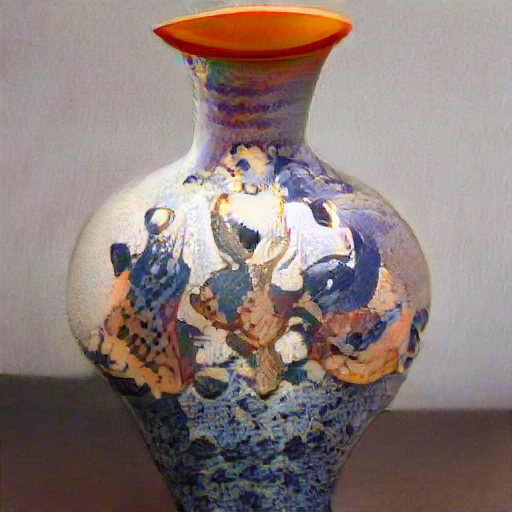

loop 0 u_size = 5
n_updated = 5
Mask sum = tensor(1483., device='cuda:0')
g = tensor(2.7801, device='cuda:0').... l_max = 0.... last_g = 10000000.0
247
loop 1 u_size = 13
n_updated = 8
Mask sum = tensor(9815., device='cuda:0')
g = tensor(1.9239, device='cuda:0').... l_max = tensor(2.7801, device='cuda:0').... last_g = tensor(2.7801, device='cuda:0')
245
loop 2 u_size = 25
n_updated = 8
Mask sum = tensor(12583., device='cuda:0')
g = tensor(2.6834, device='cuda:0').... l_max = tensor(2.7801, device='cuda:0').... last_g = tensor(1.9239, device='cuda:0')
246
loop 3 u_size = 42
n_updated = 11
Mask sum = tensor(19098., device='cuda:0')
g = tensor(2.3144, device='cuda:0').... l_max = tensor(2.7801, device='cuda:0').... last_g = tensor(2.6834, device='cuda:0')
250


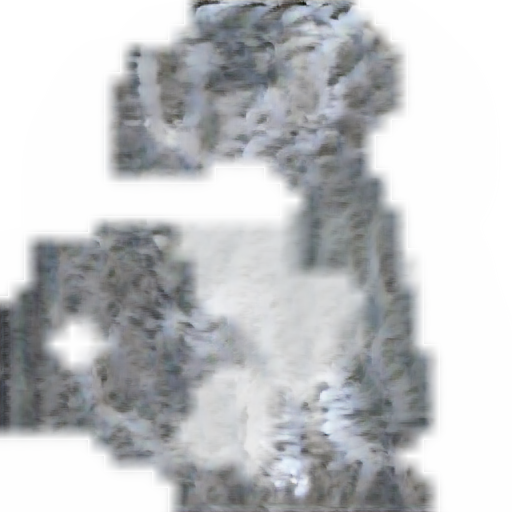

loop 4 u_size = 65
n_updated = 25
Mask sum = tensor(27454., device='cuda:0')
g = tensor(2.5920, device='cuda:0').... l_max = tensor(2.7801, device='cuda:0').... last_g = tensor(2.3144, device='cuda:0')
250
loop 5 u_size = 93
n_updated = 30
Mask sum = tensor(35388., device='cuda:0')
g = tensor(2.4278, device='cuda:0').... l_max = tensor(2.7801, device='cuda:0').... last_g = tensor(2.5920, device='cuda:0')
255
loop 6 u_size = 127
n_updated = 30
Mask sum = tensor(43555., device='cuda:0')
g = tensor(2.2867, device='cuda:0').... l_max = tensor(2.7801, device='cuda:0').... last_g = tensor(2.4278, device='cuda:0')
255
loop 7 u_size = 167
n_updated = 38
Mask sum = tensor(56445., device='cuda:0')
g = tensor(2.2606, device='cuda:0').... l_max = tensor(2.7801, device='cuda:0').... last_g = tensor(2.2867, device='cuda:0')
255


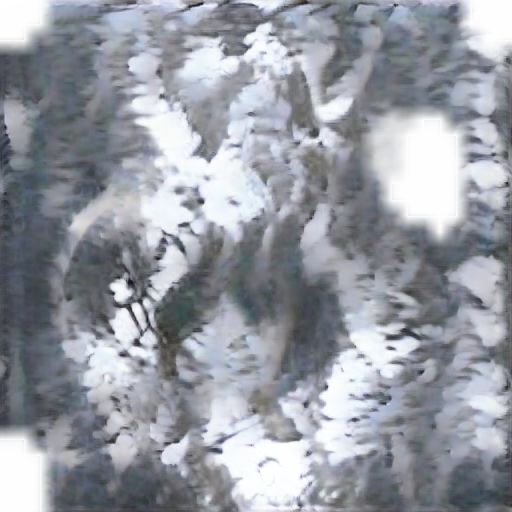

loop 8 u_size = 214
n_updated = 49
Mask sum = tensor(76667., device='cuda:0')
g = tensor(2.2548, device='cuda:0').... l_max = tensor(2.7801, device='cuda:0').... last_g = tensor(2.2606, device='cuda:0')
255
loop 9 u_size = 267
n_updated = 56
Mask sum = tensor(92182., device='cuda:0')
g = tensor(2.2657, device='cuda:0').... l_max = tensor(2.7801, device='cuda:0').... last_g = tensor(2.2548, device='cuda:0')
255
loop 10 u_size = 326
reached 84 stroke checks. R[0, 174, 13, 21] = 1.5889237  m_updated 85 after 85 checks
n_updated = 72
Mask sum = tensor(113487., device='cuda:0')
g = tensor(2.2558, device='cuda:0').... l_max = tensor(2.7801, device='cuda:0').... last_g = tensor(2.2657, device='cuda:0')
255
loop 11 u_size = 393
n_updated = 90
Mask sum = tensor(147583., device='cuda:0')
g = tensor(2.1141, device='cuda:0').... l_max = tensor(2.7801, device='cuda:0').... last_g = tensor(2.2558, device='cuda:0')
255


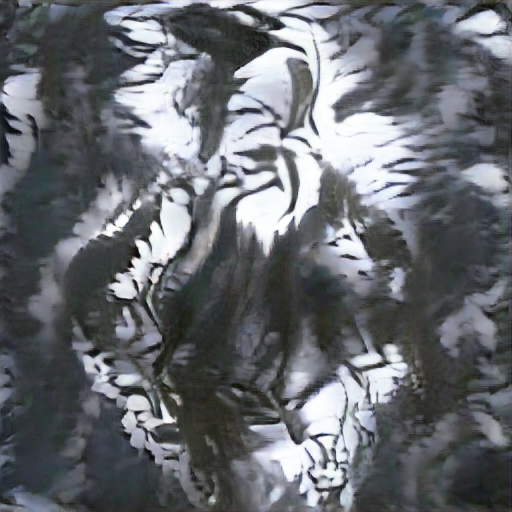

loop 12 u_size = 467
n_updated = 104
Mask sum = tensor(181220., device='cuda:0')
g = tensor(2.0950, device='cuda:0').... l_max = tensor(2.7801, device='cuda:0').... last_g = tensor(2.1141, device='cuda:0')
255
loop 13 u_size = 548
n_updated = 117
Mask sum = tensor(216400., device='cuda:0')
g = tensor(2.0892, device='cuda:0').... l_max = tensor(2.7801, device='cuda:0').... last_g = tensor(2.0950, device='cuda:0')
255
loop 14 u_size = 637
n_updated = 129
Mask sum = tensor(252578., device='cuda:0')
g = tensor(2.0415, device='cuda:0').... l_max = tensor(2.7801, device='cuda:0').... last_g = tensor(2.0892, device='cuda:0')
255
loop 15 u_size = 733
n_updated = 149
Mask sum = tensor(284833., device='cuda:0')
g = tensor(2.0256, device='cuda:0').... l_max = tensor(2.7801, device='cuda:0').... last_g = tensor(2.0415, device='cuda:0')
255


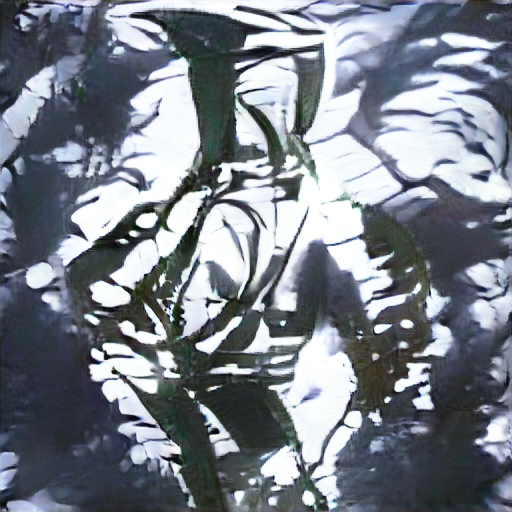

loop 16 u_size = 838
n_updated = 170
Mask sum = tensor(323384., device='cuda:0')
g = tensor(2.0347, device='cuda:0').... l_max = tensor(2.7801, device='cuda:0').... last_g = tensor(2.0256, device='cuda:0')
255
loop 17 u_size = 950
n_updated = 203
Mask sum = tensor(372250., device='cuda:0')
g = tensor(1.9191, device='cuda:0').... l_max = tensor(2.7801, device='cuda:0').... last_g = tensor(2.0347, device='cuda:0')
255
loop 18 u_size = 1070
n_updated = 226
Mask sum = tensor(408493., device='cuda:0')
g = tensor(1.9171, device='cuda:0').... l_max = tensor(2.7801, device='cuda:0').... last_g = tensor(1.9191, device='cuda:0')
255
loop 19 u_size = 1198
n_updated = 243
Mask sum = tensor(451077., device='cuda:0')
g = tensor(1.9059, device='cuda:0').... l_max = tensor(2.7801, device='cuda:0').... last_g = tensor(1.9171, device='cuda:0')
255


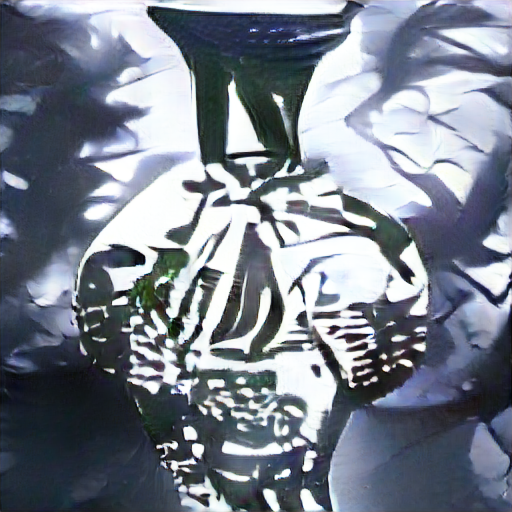

loop 20 u_size = 1335
n_updated = 268
Mask sum = tensor(490319., device='cuda:0')
g = tensor(1.9255, device='cuda:0').... l_max = tensor(2.7801, device='cuda:0').... last_g = tensor(1.9059, device='cuda:0')
255
loop 21 u_size = 1480
n_updated = 302
Mask sum = tensor(550507., device='cuda:0')
g = tensor(1.8606, device='cuda:0').... l_max = tensor(2.7801, device='cuda:0').... last_g = tensor(1.9255, device='cuda:0')
255
loop 22 u_size = 1634
reached 84 stroke checks. R[0, 7, 18, 11] = 1.1829009  m_updated 85 after 85 checks
reached 84 stroke checks. R[0, 608, 18, 22] = 1.2247809  m_updated 85 after 85 checks
reached 84 stroke checks. R[0, 608, 12, 26] = 1.2148812  m_updated 85 after 85 checks
n_updated = 332
Mask sum = tensor(614298., device='cuda:0')
g = tensor(1.8835, device='cuda:0').... l_max = tensor(2.7801, device='cuda:0').... last_g = tensor(1.8606, device='cuda:0')
255
loop 23 u_size = 1796
reached 84 stroke checks. R[0, 798, 15, 19] = 1.060766  m_updated 85 after 85 checks
reac

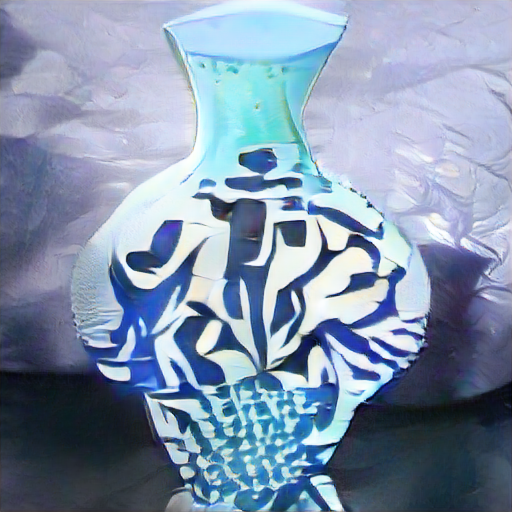

loop 24 u_size = 1968
reached 84 stroke checks. R[0, 438, 6, 0] = 1.0027139  m_updated 85 after 85 checks
reached 84 stroke checks. R[0, 438, 3, 0] = 0.9846489  m_updated 85 after 85 checks
reached 84 stroke checks. R[0, 542, 11, 0] = 0.8783217  m_updated 85 after 85 checks
reached 84 stroke checks. R[0, 87, 11, 0] = 1.0692219  m_updated 85 after 85 checks
reached 84 stroke checks. R[0, 87, 14, 0] = 0.82212895  m_updated 85 after 85 checks
reached 84 stroke checks. R[0, 87, 17, 0] = 0.7571465  m_updated 85 after 85 checks
reached 84 stroke checks. R[0, 387, 16, 0] = 1.1272081  m_updated 85 after 85 checks
reached 84 stroke checks. R[0, 387, 11, 0] = 0.71794873  m_updated 85 after 85 checks
reached 84 stroke checks. R[0, 387, 5, 0] = 0.7888848  m_updated 85 after 85 checks
reached 84 stroke checks. R[0, 455, 10, 31] = 1.2284125  m_updated 85 after 85 checks
reached 84 stroke checks. R[0, 455, 18, 31] = 0.6785523  m_updated 85 after 85 checks
reached 84 stroke checks. R[0, 784, 17, 31] =

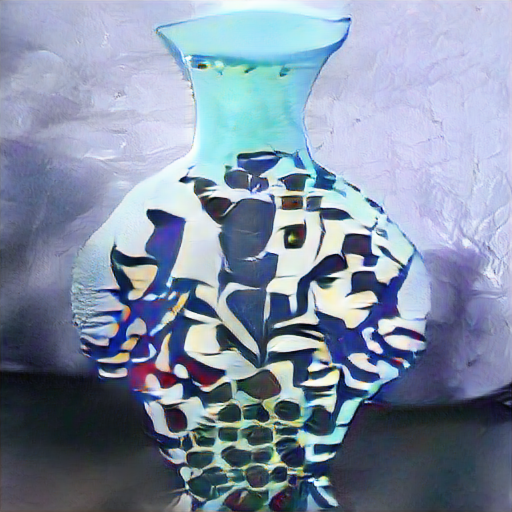

Original network output


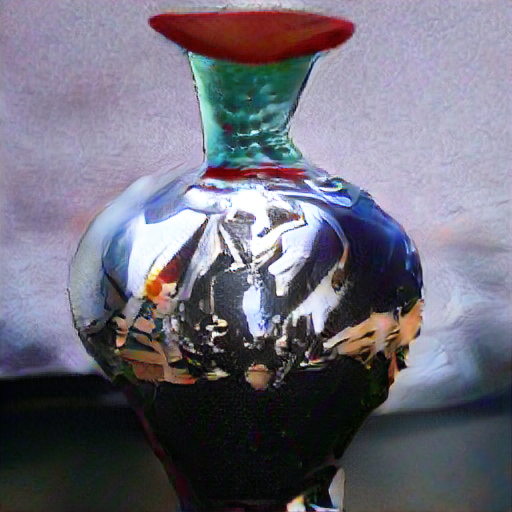

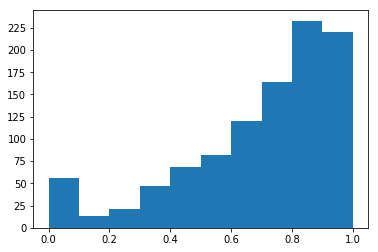

In [32]:
    
    torch.set_grad_enabled(False)
    do_paint = True

    
    outfile_prefix = 'demo/' + ''.join(class_label)
    OUTPUT_NAME = outfile_prefix + "_L" + str(painter_layer) + "_FR" + str(frame_rate) + "_GB" + str(gain_bump) + "TB" + str(time_bump) + \
                        "_GT" + str(gain_threshold) + "r" + str(stop_threshold) + \
                        "_CH" + ("all" if full_stroke else str(max_ch)) + \
                        "_ST" + str(stroke_size) + "s" + str(stroke_scope) + "m" + str(min_stroke_match) + "p" + str(penetrate) + \
                        "_MASK" + str(mask_base) + "k" + str(mask_kernel) + "b" + str(mask_blur) + \
                        "_COST" + str(channel_cost) + "m" + str(move_cost) + "b" + str(bias_cost) + "f" + str(bias_cost_first) + "c" + str(bias_centrality)
    
    PIC_FOLDER = "/content/drive/My Drive/Colab Notebooks/painter_out/biggan/" + OUTPUT_NAME
    if not os.path.exists(PIC_FOLDER):
        os.makedirs(PIC_FOLDER)
    PIC_FILE = PIC_FOLDER + "/$PIC_loop$LOOP.jpg"
    VIDEO_STREAM_OUT = "/content/drive/My Drive/Colab Notebooks/painter_out/biggan/" + OUTPUT_NAME + ".avi"
    TEXT_OUT = open("/content/drive/My Drive/Colab Notebooks/painter_out/biggan/" + OUTPUT_NAME + "/_TEXT_OUT.txt", 'w')
    
    bgd = BGANdraw(model, noise_vector, class_vector, TEXT_OUT=TEXT_OUT)
    o = bgd.setPainterLayer(painter_layer, max_ch=max_ch, stop_stroke=stop_stroke, full_stroke=full_stroke
                            , stroke_size=stroke_size, min_stroke_match=min_stroke_match, penetrate=penetrate
                            , channel_cost=channel_cost, move_cost=move_cost, bias_cost=bias_cost, bias_cost_first=bias_cost_first, bias_centrality=bias_centrality
                            , stop_threshold=stop_threshold, new_frame_ch=new_frame_ch, random_walk=random_walk
                           )
    (b, ch, h, w) = o.size()
    o = tensor_to_image(o)
    display(Image.fromarray(o))
    Image.fromarray(o).save(PIC_FOLDER + "/_FULL.jpg")
    if blank_canvas:
        o = 255 * np.ones((h, w), dtype=np.uint8)
        o = np.stack((o,)*3, axis=-1)

    
    side = None
    if gifout:
        out = imageio.get_writer(VIDEO_STREAM_OUT.replace('.avi','.gif'), fps=frame_rate)
    else:
        out = cv2.VideoWriter(VIDEO_STREAM_OUT, cv2.VideoWriter_fourcc(*"XVID"), frame_rate, (w, h), True)
    for i in range(int(burn_in_secs*frame_rate)):
        write_video(out, m[:,:,::-1], side, gifout)
    
    
    
    x = None
    i = 0
    l_max = 0
    last_g = 10e6
    
    bgd.setPainterJob()
    
    while do_paint:
        m, g, stop_ch = bgd.paint(i, gain_bump *  time_bump ** np.log2(i+2))
        print("g = " + str(g) + ".... l_max = " + str(l_max) + ".... last_g = " + str(last_g))
        if TEXT_OUT:
            TEXT_OUT.write("g = " + str(g) + ".... l_max = " + str(l_max) + ".... last_g = " + str(last_g) + "\n")
        if not l_max:
            l_max = g
        m = tensor_to_image(m)
        m = forward_mask(m, bgd, o, blank_canvas, reverse, mask_base, mask_kernel, mask_blur, PIC_FILE.replace("$LOOP",str(i)))
        i += 1
        write_video(out, m, side, gifout)
        if i % int(display_skip_frames+1) == 0:
            display(Image.fromarray(m, 'RGB'))

        if g>1e6:
            break

        if stop_ch and new_frame_ch:
            for i in range(int(step_secs*frame_rate)):
                write_video(out, m, side, gifout)
        
        if g/l_max < gain_threshold or i*1.0/frame_rate >= max_sec_per_roi:
            break

        last_g = g
        X = bgd.getPainterState()
        
    print("CPIA final image")
    display(Image.fromarray(m, 'RGB'))
    Image.fromarray(m).save(PIC_FOLDER + "/_FINAL.jpg")
    
    for i in range(int(burn_out_secs*frame_rate)):
        write_video(out, m, side, gifout)
    if gifout:
        out.close()
    else:
        out.release()
    
    TEXT_OUT.close()
    
    m = bgd.getFixedChPaint()
    m = tensor_to_image(m)
    print("Original network output")
    display(Image.fromarray(m))
    Image.fromarray(m).save(PIC_FOLDER + "/_FIXED_CH.jpg")
    
    
    (b, ch, h, w ) = bgd.M.size()
    H = bgd.M.view(1,ch,-1).sum(2) / (h*w)
    H = H[0].cpu().numpy()
    ax = plt.figure().gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.hist(H, range=(0,1), bins=10)
    s = bgd.M.sum() / (ch*w*h)
    s = s.cpu().numpy()
    plt.savefig(PIC_FOLDER + "/_HIST_r"+str(s)+".svg", format='svg', dpi=1000)
    plt.savefig(PIC_FOLDER + "/_HIST_r"+str(s)+".eps", format='eps', dpi=1000)
